# Big Data Technologies Coursework
## CS982

### US Census Income Data Set
available at: https://archive.ics.uci.edu/ml/datasets/census+income

<b> Name: </b> Eren Ayvaz <br>
<b> Reg No: </b> 2020....

<hr>

## Libraries
Before we can begin we must first import the required libraries and frameworks.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import time

from sklearn import preprocessing

# Imports mainly for unsupervised learning section
from sklearn.preprocessing import scale
from sklearn import datasets
from sklearn import metrics
from sklearn import cluster

# Imports mainly for supervised learning section
from sklearn.model_selection import train_test_split as t_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline

## Importing the Data
Now lets start by first importing the adult data csv file into the script and storing it as a dataframe. 

In [2]:
# the adult_data and adult_test files that comes with this dataset do not have the column names included in the csv
# therefore i will define them below to add to the dataframe.
column_names = ["age","workclass","fnlwgt","education","education_num","marital_status","occupation",
               "relationship","race","sex","capital_gain","capital_loss","hours_per_week","native_country","salary"]

# load both files (one was for training and other for test) independantly 
adult_temp = pd.read_csv("./data/adult_data.csv", names = column_names, header = None)
test_temp = pd.read_csv("./data/adult_test.csv", names = column_names, skiprows = 1)

# Concatenate both these datasets into one dataframe for use for the rest of the project
df = pd.concat([adult_temp,test_temp])

## Initial look at the data
Now we have the data imported we can have a look at its shape, range of values etc.

In [3]:
# View the dataframes shape
print("----- Shape of the data: -----\n{} \n".format(df.shape))

# View the value types of each attribute
print("----- Values and types in the data: -----\n{} \n".format(df.dtypes))

# View the number of unique values for each attribute
print("----- No. of unique values for each attribute: -----\n{} \n".format(df.nunique()))

# View an example row from the data
print("--------------- Example row from dataset: ---------------")
df.head(1)


----- Shape of the data: -----
(48842, 15) 

----- Values and types in the data: -----
age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
salary            object
dtype: object 

----- No. of unique values for each attribute: -----
age                  74
workclass             9
fnlwgt            28523
education            16
education_num        16
marital_status        7
occupation           15
relationship          6
race                  5
sex                   2
capital_gain        123
capital_loss         99
hours_per_week       96
native_country       42
salary                4
dtype: int64 

--------------- Example row from dataset: ---------------


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K


<b> Conclusions from initial look </b><br>
We can see from a very basic look at the structure of the data that it seems to follow the following format: </n>
- age: an interger number representing the age of the person.
- workclass: 9 possible string values (object) representing their work class.
- fnlwgt: some sort of weighting value that is not yet apparent as to how it is associated with the data in a integer form.
- education: 16 possible levels of education in string values.
- education-num: a numberical representation of the above attribute.
- marital-status: 7 possible variations on the marital-status of the person in string format.
- occupation: 15 possible occupations the person can have, again in string format.
- relationship: 6 different relationships status in string format.
- race: the race of the individual from a possible 5 string values.
- sex: the sex of the person, male or female in string format.
- capital-gain: the capital gain of a person, in integer form.
- capital-loss: the capital loss of a person, in integer form.
- hours-per-week: the hours a person works per week in interger form.
- native-country: the nation a person is native to from a possible 42 nations, in string format.
- salary: a string value indicating if a person makes less than or equal to $50k per year or higher.

We also see there are <b>48842 instances</b> of this data.

## Pre-processing of the data
before any meaningful work can can take place it would first make sense to pre-process the data to deal with issues such as missing values, duplicates, redundant attributes etc. 

### Valid values
To begin we will make sure there are no values in the dataset that should not be there.

In [4]:
# for each column in the dataframe print its name and all the unique values from it
for column in df.columns.values:
    print("------------------------------ {:^14} ------------------------------\n".format(column))
    print("{}\n".format(df[column].unique()))

------------------------------      age       ------------------------------

[39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87 89]

------------------------------   workclass    ------------------------------

[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']

------------------------------     fnlwgt     ------------------------------

[ 77516  83311 215646 ... 173449  89686 350977]

------------------------------   education    ------------------------------

[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']

------------------------------ education_num  ------------------------------

[13  9  7 14  5 1

All the values found here correspond to valid values that can occur in the dataset other than the '?' value found in a number of columns, it's likely these are just missing values encoded as '?' rather than an empty space. therefore we will replace all values with None values. There is also the case where the salary values sometimes have a '.' at the end and all other string values have some leading whitespace, these will also be removed.

In [5]:
df = df.replace(' ?', np.NaN)
df['salary'] = df['salary'].str.rstrip(".")
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda value: value.str.strip())

### Duplicates
we will now look for any duplicate values in the data and remove them where necessary.

In [6]:
# gather any duplicated values by using the duplicated function to return true for any rows that are duplicates 
# and then storing these values in a new dataframe called dups
dups = df[df.duplicated()]

print("----- No. of duplicated rows: -----\n{} \n".format(len(dups)))

----- No. of duplicated rows: -----
52 



In [7]:
print("----- No. of rows before removal: -----\n{} \n".format(len(df)))

# remove the duplicate rows from df
df = df.drop_duplicates()

print("----- No. of rows after removal: -----\n{} \n".format(len(df)))

----- No. of rows before removal: -----
48842 

----- No. of rows after removal: -----
48790 



### Missing values
we will now look for any missing values in the data and handle them.

In [8]:
# find the number of missing values
print("----- No. of missing values: -----\n{} \n".format(df.isnull().sum()))

----- No. of missing values: -----
age                  0
workclass         2795
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        2805
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     856
salary               0
dtype: int64 



you can see there is a small amount of missing values (relative to the size of the dataset), we can now figure out the exact amount of rows with missing values rather than just the total number of missing values as some rows might be responsible for more than 1 missing value.

In [9]:
# get the total number of rows - the number of rows after dropping missing values
# to determine the number of rows which contain these missing values
df.shape[0] - df.dropna().shape[0]

3615

you can see there are <b>only 3615 rows responsible for these missing values</b> in the dataset which equates to around 7% of the dataset, as this is a relatively small amount (<10%) and can not be replaced with averages etc. worked out from other columns we can just go ahead and drop these rows from the set.

In [10]:
df.dropna(inplace=True) # with inplace = true, i.e. to the same dataframe without having to reassign to a new one

## Data Exploration and Analysis
Now it's time to have a look at the contents of the dataset itself.

### Looking for correlations
it would now be a good idea to look at how the values for columns are correlated to get an idea of the structure in the data itself. Firstly, we noted earlier that education-num was just a integer representation of the 16 different types of education, we will now check to see if this is indeed the case.

In [11]:
for i in range(1,17):
    print(df.loc[df["education_num"]==i, ["education","education_num"]].head(1)["education"])
    print("{}\n".format(df.loc[df["education_num"]==i, ["education","education_num"]].nunique()))

224    Preschool
Name: education, dtype: object
education        1
education_num    1
dtype: int64

416    1st-4th
Name: education, dtype: object
education        1
education_num    1
dtype: int64

56    5th-6th
Name: education, dtype: object
education        1
education_num    1
dtype: int64

15    7th-8th
Name: education, dtype: object
education        1
education_num    1
dtype: int64

6    9th
Name: education, dtype: object
education        1
education_num    1
dtype: int64

219    10th
Name: education, dtype: object
education        1
education_num    1
dtype: int64

3    11th
Name: education, dtype: object
education        1
education_num    1
dtype: int64

415    12th
Name: education, dtype: object
education        1
education_num    1
dtype: int64

2    HS-grad
Name: education, dtype: object
education        1
education_num    1
dtype: int64

10    Some-college
Name: education, dtype: object
education        1
education_num    1
dtype: int64

48    Assoc-voc
Name: education, dt

You can see above that this is indeed the case and as such it seems a bit <b> redundant to have both education and education-num in the dataset </b>, therefore the education column will be removed from the data.

In [12]:
# drop the education column inplace, i.e. to the dataframe without having to reassign to a new one
df.drop("education", axis=1, inplace=True) 

It should also be noted that there is <b>no real need for both capital loss and gain features</b> as these can be reduced to a single feature where capital = capital gain - capital loss. this is done below:

In [13]:
df['capital'] = df['capital_gain'] - df['capital_loss']
df.drop(columns=['capital_gain', 'capital_loss'], axis=1, inplace=True)

We will now produce a correlation matrix (heatmap) to see how the remaining features relate to each other

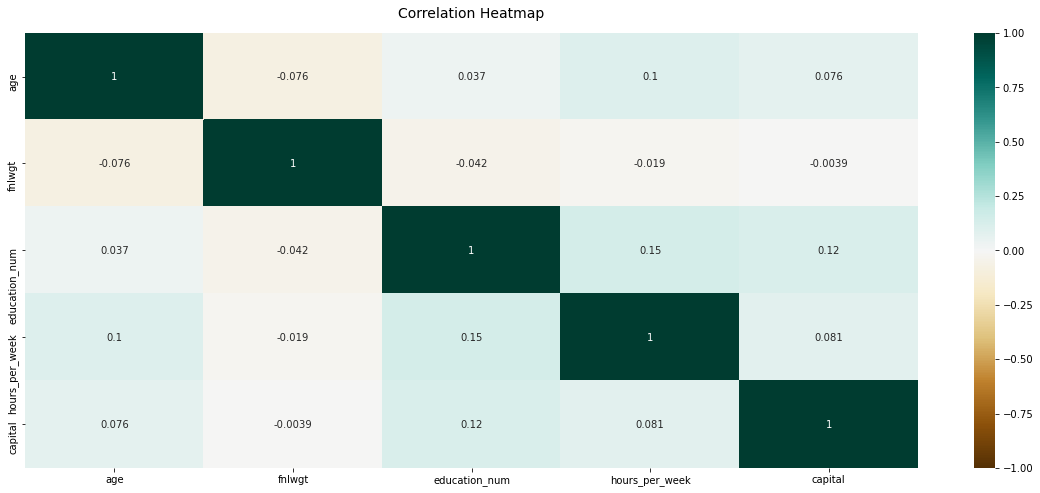

In [14]:
# define the size of the heatmap to be created
plt.figure(figsize=(20, 8))

# use the .corr() method to get the correlation between features and create an sns heatmap with it, with a max/min of 1/-1
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

# Set the title, increase the font size and add some padding to bottom of the title
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=15);

As you can see above there is not any large degree of correlation between the features in the dataset that are integer values. but this doesn't take into account all the categorical values in the data, we can do that below:

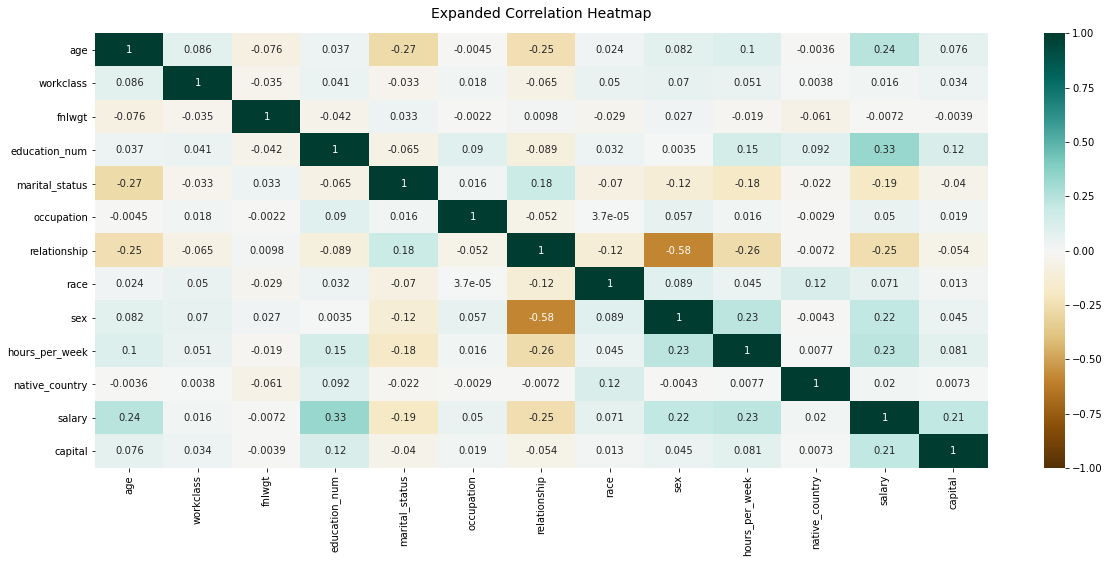

In [15]:
# use a deep copy (copy of the df without pointer so changed to new dataframe will not be reflected in normal df)
df_copy = df.copy(deep=True)

# get a list of all columns in the dataset that have the type object, i.e. are strings
obj_column_names = df_copy.select_dtypes(include = "object").columns

# for each column in this list encode the label to values that can be used in the correlation heatmap (numbers)
for column in obj_column_names:
    df_copy[column] = preprocessing.LabelEncoder().fit_transform(df_copy[column].astype(str))

# Now plot the new heatmap
plt.figure(figsize=(20, 8))

# use the .corr() method to get the correlation between features and create an sns heatmap with it, with a max/min of 1/-1
heatmap = sns.heatmap(df_copy.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

# Set the title, increase the font size and add some padding to bottom of the title
heatmap.set_title('Expanded Correlation Heatmap', fontdict={'fontsize':14}, pad=15);

This new correlation heatmap gives a much greater insight into the underlying correlations in the data than the previous ones.
<br><br>
<b>some more notable takeaways from this are</b>:
- sex is fairly highly negatively correlated with relationship status 
- education-num (or just education level) is lightly positively correlated with salary 
- age is lightly positively correlated with salary
- marital status is lightly negatively correlated with age 
- hours worked per week is lightly negatively correlated with relationship status 
- salary is lightly positively correlated with  hours worked per week

### Feature Distributions
Finally for the analysis we can have a look at the distributions of some of the more interesting  features of the dataset.

#### Age
This first boxplot gives us a view of the underlying distribution of age in the dataset.<br>
As you can see there is a right skew to this distribution and a median value of around 36-38, you can also see there are a number of outliers to the right of the maximum as well. The interquartile range for the age (25th to 75th percentile) falls between around 28 years up to 48 years.
<br><br>
This same data is then visualised in a histogram for a different look at the same idea.
<br><br>
This means the majority of peoples data which resides in this dataset comes from middle aged people living in the US.

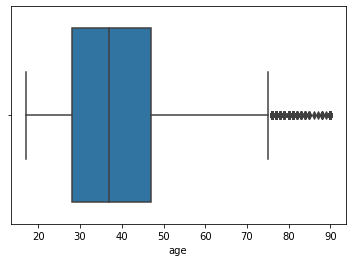

In [16]:
sns.boxplot(x=df["age"])
plt.show()

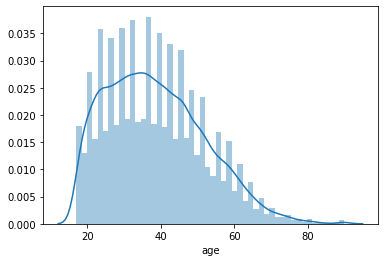

In [17]:
sns.distplot(df['age'])
plt.show();

#### Sex
Looking at the distribution of Sex in the dataset is fairly straightforward as there are only two discrete values unlike previously. <br><br>
You can see from the countplot that the number of males in the data set roughly outnumber the females 2:1.
<br><br>
A boxplot showing the distribution of age over both male and females has also been added to link back to the first feature.

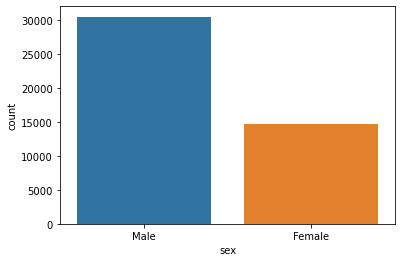

In [18]:
sns.countplot(x="sex",data=df)
plt.show()

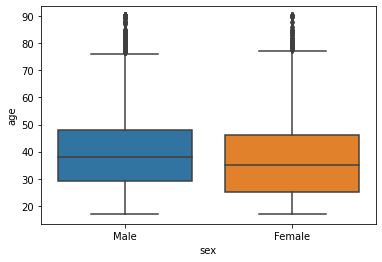

In [19]:
sns.boxplot(df['sex'], df['age']);
plt.show();

#### Race
we will now take a quick look at the distribution of races over the dataset.<br><br>
As you can see below the vast majority of people in the dataset are white, with a smaller minority being black (around 10%) and an even smaller minority being asian, eskimo or other. 
<br><br>
Below even that you can then see a roughly equivalent number of males to females in all but Whites where the males again outnumber females by 2:1.


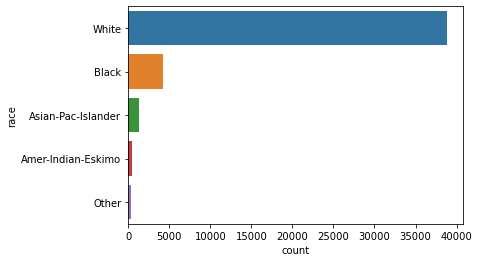

In [20]:
sns.countplot(y="race",data=df) # use horizontal because of long label names
plt.show()

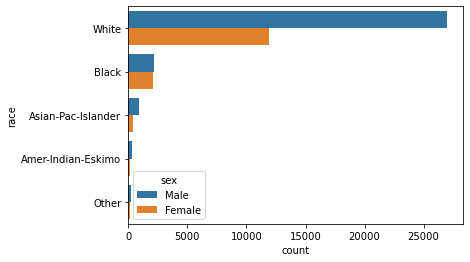

In [21]:
fig, ax = plt.subplots()

sns.countplot(y="race", hue="sex", data=df) 

plt.show()

#### Education Levels
A similar approach to observing race in the dataset was taken for education levels too, firsly using a countplot to view the overall distribution of education levels obtained by people in the dataset and then comparing these to education levels for each sex.
<br><br>
The levels of female to males seem to closely match the overall distribution of female to males in all education levels but Prof School and Doctorates indicating that males were more likely to achieve the highest 2 levels of education.

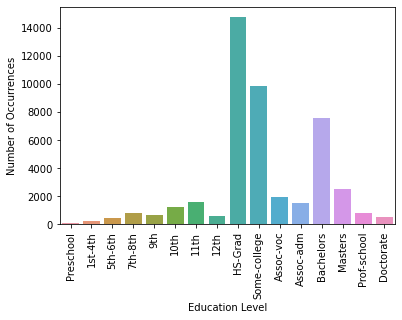

In [22]:
# define the education levels in order to replace education-num labels on the graph
education_levels = ["Preschool", "1st-4th", "5th-6th", "7th-8th", "9th", "10th", "11th",
                  "12th", "HS-Grad", "Some-college", "Assoc-voc", "Assoc-adm", "Bachelors", 
                   "Masters", "Prof-school", "Doctorate"]

fig, ax = plt.subplots()

ax = sns.countplot(x="education_num", data=df) 
ax.set_xlabel('Education Level')
ax.set_ylabel('Number of Occurrences')
ax.set_xticklabels(education_levels, rotation='vertical', fontsize=10)

plt.show()

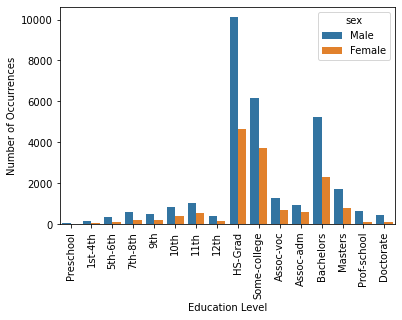

In [23]:
fig, ax = plt.subplots()

ax = sns.countplot(x="education_num", hue="sex", data=df) 
ax.set_xlabel('Education Level')
ax.set_ylabel('Number of Occurrences')
ax.set_xticklabels(education_levels, rotation='vertical', fontsize=10)

plt.show()

#### Salary
Below is just a simple pie chart outlining the amount of people who earn over 50k dollars per year (24.8%) compared to the rest of the people in the dataset who make less than or equal to 50k dollars a year (75.2%).
<br><br>
Secondly, there is a bar graph that tries to capture the ratio of men to women who make over 50k dollars per year, as you can see there is much more men who earn higher than women.
<br><br>
Afterwards, there is a bar graph that tries to capture the ratio ofthe different races and how much they earn. The pattern seems to just follow the ratio of races in the population compared to the overall ratio of people earning 50k or above (around 25%) with white people only slightly faring better than just the 25% and population ratio would suggest. this indicates that salary isn't overly dependent on race. 
<br><br>
Finally, there is a bar graph that tries to see the distribution of different education levels over the two salary brackets. It shows that people with higher education levels in general earn more and interestingly if the person was within the highest 3 levels (Bachelors, Prof School or Doctorates) they were more likely to earn in the higher bracket than they were the lower bracket.

<=50K    33973
>50K     11202
Name: salary, dtype: int64


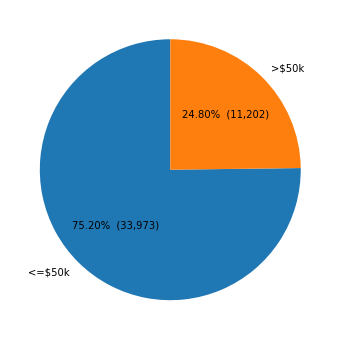

In [24]:
fig = plt.gcf()
fig.set_size_inches(6,6)
print(df.loc[:,"salary"].value_counts())

plt.pie(df.loc[:,"salary"].value_counts(), # get the value counts for the salary feature
        labels=["<=$50k",">$50k"],  # define labels
        autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(df.loc[:,"salary"].value_counts())/100), # display % and number
        startangle=90, # starting angle is 90
       )

plt.show()

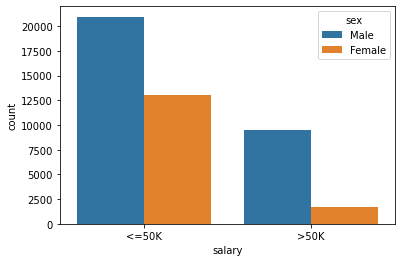

In [25]:
fig, ax = plt.subplots()

ax = sns.countplot(x="salary", hue="sex", data=df) 

plt.show()

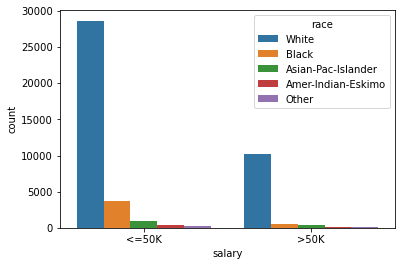

In [26]:
fig, ax = plt.subplots()

ax = sns.countplot(x="salary", hue="race", data=df) 

plt.show()

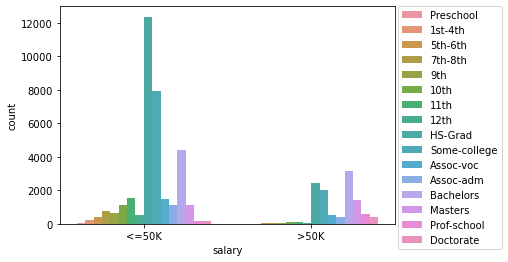

In [27]:
fig, ax = plt.subplots()

ax = sns.countplot(x="salary", hue="education_num", data=df) 
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0, labels=education_levels)

plt.show()

#### Hours per week vs age with salaries
For the final look at how the features are distributed we're going to look at the hours per week worked by different age groups and what that equates to in salary. This will be done using a scatter plot of Hours worked vs Age with a hue of their salary superimposed ontop.
<br><br>
We can see from this that people who earn over 50k per year, i.e. the top 24.8%, are usually between 30 and 65  and work upwards of 40 hours per week.

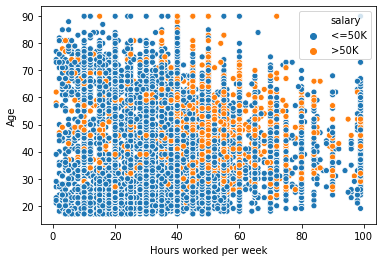

In [28]:
sns.scatterplot(df["hours_per_week"], df["age"], hue = df["salary"])
plt.xlabel("Hours worked per week")
plt.ylabel("Age")
plt.show();

#### Conclusions
There some more conclusions that can be made from these results:
- The majority of the dataset are middle aged between 28 and 48
- There is roughly 2x as many men in the dataset compared to women
- Majority are white, minority being black (around 10%) and an even smaller minority being asian, eskimo or other.
- The 3 most common education types are (in order): HS Grads, Some college and Bachelor degree holders
- Only a very small minority of people hold a masters or doctorate
- The levels of female to males seem to closely match the overall distribution of female to males in all education levels except Prof School and Doctorates indicating that males were more likely to achieve the highest 2 levels of education.
- Only 24.8% of the dataset earn more than 50k per year, of this under 25% were female, which does not line up with the ratio of men to women in general, indicating women were less likely to make over 50k.
- Being Non-White does not overly impact ability to earn over 50k per year.
- People with higher education levels in general earn more and interestingly if the person was within the highest 3 levels (Bachelors, Prof School or Doctorates) they were more likely to earn in the higher bracket than they were the lower bracket.
- People who make over 50k per year are usually between ages 30 and 65 and work upwards of 40 hours per week.


## Prepare Data for Learning
Before we can apply any supervised or unsupervised techniques we must first transform the data into a form that can be easier interpreted by the algorithms

### Grouping by race
As found out previously in the analysis stage the race of someone does not overly affect their chances of earning higher, so it would make sense to group race into: White, Black, Others. to reduce the complexity and hopefully help the algorithm out a bit later.

In [29]:
df['race'] = np.where( (df['race'] == "Asian-Pac-Islander"), "Other", df['race'])
df['race'] = np.where( (df['race'] == "Amer-Indian-Eskimo"), "Other", df['race'])
df["race"].unique() # check the unique values are only White, Black and Other


array(['White', 'Black', 'Other'], dtype=object)

### Grouping by Nationality
As it can be assumed a similar correlation is present with native countries we will now do the same for nationalities where there will be: US, European, Asian and Other.

In [30]:
"""
HERE IS THE LIST OF COUNTRIES TO REFRESH OUR MEMORY
    
 ' United-States' ' Cuba' ' Jamaica' ' India' ' ?' ' Mexico' ' South'
 ' Puerto-Rico' ' Honduras' ' England' ' Canada' ' Germany' ' Iran'
 ' Philippines' ' Italy' ' Poland' ' Columbia' ' Cambodia' ' Thailand'
 ' Ecuador' ' Laos' ' Taiwan' ' Haiti' ' Portugal' ' Dominican-Republic'
 ' El-Salvador' ' France' ' Guatemala' ' China' ' Japan' ' Yugoslavia'
 ' Peru' ' Outlying-US(Guam-USVI-etc)' ' Scotland' ' Trinadad&Tobago'
 ' Greece' ' Nicaragua' ' Vietnam' ' Hong' ' Ireland' ' Hungary'
 ' Holand-Netherlands'
 
"""
# define regions
asian = ["Thailand", "Laos", "Cambodia", "Taiwan", "China", "Japan", "Vietnam", "Hong"]
european = ["England", "Germany", "Italy", "Poland", "Portugal", "France", 
            "Yugoslavia", "Scotland", "Greece", "Ireland", "Hungary", "Holand-Netherlands"] 

# define regions that would not be classed as Other
notOther = ["Asian", "European", "United-States"]

# for all values that are in the european list change their value to European
df.loc[df["native_country"].isin(european), "native_country"] = "European"
# for all values that are in the asian list change their value to Asian
df.loc[df["native_country"].isin(asian), "native_country"] = "Asian"
# for all values that are not in the notOther list change their value to Other
df.loc[~df["native_country"].isin(notOther), "native_country"] = "Other"

df["native_country"].unique() # check the unique values are only United States, Asian, European and Other

array(['United-States', 'Other', 'European', 'Asian'], dtype=object)

### Data imbalance
As seen earlier there is many more instances of people who earn <= 50k per year compared to those that earn > 50k, this represents an imbalance in the data which would potentially add some bias to any classification algorithm we use afterwards. to tackle this we will use an undersampling technique where we shrink the instances of <=50k to match the amount that are >50k. This would be better than oversampling here as that would mean almost tripling (duplicating) the amount of >50k values which would likely result in overfitting in the algorithm. this is achieved below:

In [31]:
# put all instances of >50k in a dataset
over_df = df.loc[df["salary"] == ">50K"]

over_df.head(5)

# do the same for <=50k
under_df = df.loc[df["salary"] == "<=50K"]

# now randomly select an amount of instances from the <=50k 
# dataset that matches the size of the >50k dataset
print(len(over_df))
under_df = under_df.sample(random_state=5,n=len(over_df))

# Now add both together into one balanced dataset
balanced_df = pd.concat([over_df, under_df])

# Now print the shape and ensure they both have the same length
print(balanced_df.loc[balanced_df["salary"] == '>50K'].shape)
print(balanced_df.loc[balanced_df["salary"] == '<=50K'].shape)

11202
(11202, 13)
(11202, 13)


### String Encoding
For most algorithms to work correctly string values in the dataset must be encoded to numerical ones first. <br><br>
This will be done by using a technique called One Hot Encoding. <br><br>
This was apposed to using just label encoding, which we used earlier during the correlation heatmap stage, as that results in features  being changed numbers instead of nominal values, e.g. 0,1,2 instead of ‘low’, ‘med’, ‘high’, but this could be problematic when the values are not ordinal, such as race, or occupation. 
this is what One Hot Encoding solves by separating the these values into binary columns, e.g. a
person who is white would be: White: 1, Black: 0, Other: 0. 
<br>
This is done below using pandas dummies method.

In [32]:
balanced_df = pd.get_dummies(balanced_df, columns=["workclass", "marital_status",
                                     "occupation","relationship", "sex", "race","native_country"])

# salary is the target variable in this case we will encode it using 0s and 1s using cat codes instead of OHE 
balanced_df["salary"] = balanced_df["salary"].astype("category").cat.codes

# view the new look of the dataset
balanced_df.head(5)

,age,fnlwgt,education_num,hours_per_week,salary,capital,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,relationship_Wife,sex_Female,sex_Male,race_Black,race_Other,race_White,native_country_Asian,native_country_European,native_country_Other,native_country_United-States
7,52,209642,9,45,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
8,31,45781,14,50,1,14084,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
9,42,159449,13,40,1,5178,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1
10,37,280464,10,80,1,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,1
11,30,141297,13,40,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0


The use of this OHE technique has resulted in a total of 49 columns now compared to 13 before, this is one of the downsides of the approach and what made the earlier work reducing column numbers and grouping some features worth it as without this that number would be even higher.

## Unsupervised Learning
We are now going to see if we can cluster people by their education levels, based on their age, salary, hours per week, sex and race.

### Scale the data
The data must be scaled before any clustering can be done on it.

In [33]:
# Seperating values into x (attributes) and y (target)
x_cluster = balanced_df[['age', 'salary', 'hours_per_week', 'sex_Female', 
                         'sex_Male', 'race_Black','race_Other','race_White']]
y_cluster = balanced_df['education_num']
# scale the x data so the clustering can properly work
scaled_x = scale(x_cluster) 
# check the scaled data to make sure it worked
scaled_x[0]

array([ 0.91829878,  1.        ,  0.21238453, -0.60595487,  0.60595487,
       -0.28972769, -0.21918551,  0.37498939])

### Create k means cluster from 2 to 16 clusters (for 16 education levels)
Create multiple kmeans clusters ranging from 2 clusters to 16 to see how well they fit the data and store the scores of each in a dict.

In [34]:
n_samples, n_features = scaled_x.shape # get the number of samples and the number of features
cluster_score = {} # dict to store each cluster and its score

# loop from 2 to 20 clusters
for k in range(2, 17): 
    # create cluster with number of clusters = k and fit data
    print("Testing cluster: {}".format(k))
    kmeans = cluster.KMeans(n_clusters=k, random_state=5)
    kmeans.fit(scaled_x)
    # add results to dict
    cluster_score[k] = [metrics.silhouette_score(scaled_x, kmeans.labels_), 
                        metrics.completeness_score(y_cluster, kmeans.labels_), 
                        metrics.homogeneity_score(y_cluster, kmeans.labels_)]

Testing cluster: 2
Testing cluster: 3
Testing cluster: 4
Testing cluster: 5
Testing cluster: 6
Testing cluster: 7
Testing cluster: 8
Testing cluster: 9
Testing cluster: 10
Testing cluster: 11
Testing cluster: 12
Testing cluster: 13
Testing cluster: 14
Testing cluster: 15
Testing cluster: 16


### Find the best cluster based on scores
Look in the dictionary for the number of clusters that delivers the best result based on each metric.

In [35]:
# variables to hold the highest score for each metric
silhouette_best = [2, cluster_score[2][0]]
completeness_best = [2, cluster_score[2][1]]
homogeneity_best = [2, cluster_score[2][2]]

# loop through dict to find highest score for each 
for k in cluster_score:
    if(cluster_score[k][0] > silhouette_best[1]):
        silhouette_best = [k, cluster_score[k][0]]
    if(cluster_score[k][1] > completeness_best[1]):
        completeness_best = [k, cluster_score[k][1]]
    if(cluster_score[k][2] > homogeneity_best[1]):
        homogeneity_best = [k, cluster_score[k][2]]
        
# print results
print("{} clusters produces the best silhouette score of: {}".format(silhouette_best[0], silhouette_best[1]))
print("{} clusters produces the best completeness score of: {}".format(completeness_best[0], completeness_best[1]))
print("{} clusters produces the best homogeneity score of: {}".format(homogeneity_best[0], homogeneity_best[1]))

4 clusters produces the best silhouette score of: 0.47364358883208857
5 clusters produces the best completeness score of: 0.04816258133503143
16 clusters produces the best homogeneity score of: 0.054613486264617046


### Visualise results
We can now visualise how each cluster performed on all metrics compared to each other.

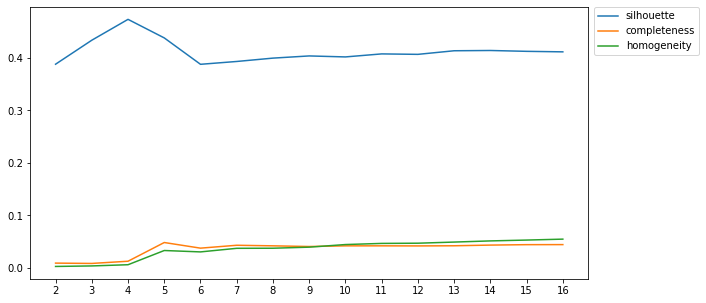

In [36]:
fig=plt.figure()
ax=plt.subplot(111)
fig.set_size_inches(10,5)

# gather all scores for each metric into a list
silhouette_list = [cluster_score[c][0] for c in cluster_score]
completeness_list = [cluster_score[c][1] for c in cluster_score]
homogeneity_list = [cluster_score[c][2] for c in cluster_score]

# gather all lists into one 2d list 
metrics = [silhouette_list, completeness_list, homogeneity_list]  

# for each metric plot on a line graph
for m in metrics:
    xval = range(2, 17)
    ax.plot(xval, m)

plt.xticks(range(2, 17))
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0, labels=["silhouette","completeness","homogeneity" ])
plt.show()

In [37]:
# determine which cluster has the best average between all 3
avg = (silhouette_list[0]+completeness_list[0]+homogeneity_list[0])/3
cls = "2"
for i in range(2,17):
    if( ((silhouette_list[i-2]+completeness_list[i-2]+homogeneity_list[i-2])/3) > avg ):
        avg=((silhouette_list[i-2]+completeness_list[i-2]+homogeneity_list[i-2])/3)
        cls = i
        
print("{} clusters produced the best average of all metrics with a score of: {:.6f}".format(cls, avg))


5 clusters produced the best average of all metrics with a score of: 0.173116


You can see that <b>none of the clusters produce good enough results</b>, going by the performance metrics, to be useful in any meaningful way,

### Quick look at agglomerative hierarchical results
As shown below agglomerative clustering provided no better results.

In [38]:
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
n_samples, n_features = scaled_x.shape
n_digits = len(np.unique(y_cluster))
Y2 = LabelEncoder().fit_transform(y_cluster)
aff = ["euclidean", "l1", "l2", "manhattan", "cosine"]
link = ["ward", "complete", "average"] 
for a in aff:
    for l in link:
        if(l=="ward" and a!="euclidean"):
           continue
        else:
            print(a,l)
            model = cluster.AgglomerativeClustering(n_clusters=n_digits, linkage=l, affinity=a)
            model.fit(scaled_x)
            print("silhouette_score = ", metrics.silhouette_score(scaled_x, model.labels_))
            print("completeness_score = ", metrics.completeness_score(Y2, model.labels_))
            print("homogeneity_score = ", metrics.homogeneity_score(Y2, model.labels_))

euclidean ward
silhouette_score =  0.38563199573838336
completeness_score =  0.041583368848537805
homogeneity_score =  0.05196076107127049
euclidean complete
silhouette_score =  0.02913743346318879
completeness_score =  0.02218462107421026
homogeneity_score =  0.017440271989008247
euclidean average
silhouette_score =  0.38351369653178974
completeness_score =  0.015611505339229257
homogeneity_score =  0.00869054247145291
l1 complete
silhouette_score =  0.19950814356113553
completeness_score =  0.020667099567428474
homogeneity_score =  0.01934022359167033
l1 average
silhouette_score =  0.37633745578853856
completeness_score =  0.014445057125476819
homogeneity_score =  0.008328615778027067
l2 complete
silhouette_score =  0.02913743346318879
completeness_score =  0.02218462107421026
homogeneity_score =  0.017440271989008247
l2 average
silhouette_score =  0.38351369653178974
completeness_score =  0.015611505339229257
homogeneity_score =  0.00869054247145291
manhattan complete
silhouette_sco

## Supervised Learning
The purpose chosen of the supervised learning algorithm will be to predict whether an individual will earn more than 50k per year or based on their other attributes.

In [39]:
# Seperating values into x (attributes) and y (target)
x = balanced_df.drop(['salary'], axis=1)
y = balanced_df['salary']

# check these are now the same length
print("shape of attributes : {}".format(x.shape))
print("shape of target : {}".format(y.shape))

shape of attributes : (22404, 48)
shape of target : (22404,)


### Splitting into Training, Validation and Test Data
The final step before we can construct any model is to split all this data into training, validation and test data. <br>
<br> We will use a standard 70/30 split for training/test and then a further 70/30 split for training/validation.

In [40]:
# Set a random state number
RANDOM_STATE = 15

# Split into training, validation and test data 80/20, 80/20
X_tmp, X_test, y_tmp, y_test = t_split(x,y, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = t_split(X_tmp, y_tmp, test_size=0.2, random_state=RANDOM_STATE)

### Model Construction
Lets first make a quick function to test any models we make:

In [41]:
from sklearn import metrics
# Function to test different algorithms
def run_model(model, x, y):
    time_start = time.time()
    
    # Use the prepared data and fit it to the model
    model = model.fit(X_train, y_train)

    print("-------- Model Trained --------\n")
    
    print ('Completed...  Time elapsed: {:.6f} seconds'.format(time.time()-time_start))

    # Prediction based on the validation set
    y_pred = model.predict(x)
    
    print("Report :\n{}".format(
        metrics.classification_report(y, y_pred)))
    
    print("Confusion Matrix :\n{}\n".format(
        metrics.confusion_matrix(y, y_pred)))

    print("Accuracy: {:.2f}%".format(
        (metrics.accuracy_score(y, y_pred)*100)))

    print("\n-------------------------------")

We are now ready to create a model, as we're trying to classify between two binary values 0 and 1 (<=50k, >50k) it would make sense to use a two-class algorithm. <br><br>
A couple of these algorithms include: 
-  Random Forests
-  K Neighbors
-  Logistic Regression
-  SVM (SVC)
<br><br>
we will look at the performance of the untuned versions of these 4 and move ahead with the most accurate.

#### Initial Model

In [42]:
# initialise the random forest model,
# use the same RANDOM STATE where applicable for proper comparison with a tuned model later
random_forest = RandomForestClassifier(random_state = RANDOM_STATE) 
kNeighbors = KNeighborsClassifier()
svc = SVC(random_state = RANDOM_STATE)
log_reg = LogisticRegression(random_state = RANDOM_STATE)

print("Forest")
# run the forest on the validation data
run_model(random_forest, X_val, y_val)

print("kN")
# run this kN on the validation data
run_model(kNeighbors, X_val, y_val)

# run this svc on the validation data
print("SVC")
run_model(svc, X_val, y_val)

print("Logistic Regression")
# run this logistic regression on the validation data
run_model(log_reg, X_val, y_val)

Forest
-------- Model Trained --------

Completed...  Time elapsed: 1.137547 seconds
Report :
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1741
           1       0.82      0.84      0.83      1844

    accuracy                           0.82      3585
   macro avg       0.82      0.82      0.82      3585
weighted avg       0.82      0.82      0.82      3585

Confusion Matrix :
[[1400  341]
 [ 303 1541]]

Accuracy: 82.04%

-------------------------------
kN
-------- Model Trained --------

Completed...  Time elapsed: 0.174158 seconds
Report :
              precision    recall  f1-score   support

           0       0.59      0.63      0.61      1741
           1       0.63      0.59      0.61      1844

    accuracy                           0.61      3585
   macro avg       0.61      0.61      0.61      3585
weighted avg       0.61      0.61      0.61      3585

Confusion Matrix :
[[1095  646]
 [ 750 1094]]

Accuracy: 61.06%



We can see here that the forest model predicts with <b> 82.04% </b> accuracy and took around 1.2 seconds to complete, this is based on the validation set. Therefore we will use the random forest for this classification problem. We will now try to tune the model to get a higher accuracy on this set before finally using our tuned model to test on the testing set.

### Tuning the Model

###### Max Depth
To try and reduce the time the algorithm takes to complete i will start by passing in a max depth the trees can reach without affecting the accuracy.

In [43]:
# try difference depths between 30 and 80
for depth in range(10, 110, 10):
    print("max depth of: {}".format(depth))
    # initialise the tuned model
    tuned_random_forest = RandomForestClassifier(random_state = RANDOM_STATE, max_depth = depth)
    
    time_start = time.time()
    
    # run this model on the validation data
    model = tuned_random_forest.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print("Accuracy: {:.2f}% (Test Set)".format(
        (metrics.accuracy_score(y_val, y_pred)*100)))
    print ('Time elapsed: {:.6f} seconds\n'.format(time.time()-time_start))

max depth of: 10
Accuracy: 82.32% (Test Set)
Time elapsed: 0.684623 seconds

max depth of: 20
Accuracy: 82.65% (Test Set)
Time elapsed: 1.026942 seconds

max depth of: 30
Accuracy: 82.15% (Test Set)
Time elapsed: 1.176646 seconds

max depth of: 40
Accuracy: 82.29% (Test Set)
Time elapsed: 1.204602 seconds

max depth of: 50
Accuracy: 82.06% (Test Set)
Time elapsed: 1.202095 seconds

max depth of: 60
Accuracy: 82.04% (Test Set)
Time elapsed: 1.198092 seconds

max depth of: 70
Accuracy: 82.04% (Test Set)
Time elapsed: 1.196117 seconds

max depth of: 80
Accuracy: 82.04% (Test Set)
Time elapsed: 1.195593 seconds

max depth of: 90
Accuracy: 82.04% (Test Set)
Time elapsed: 1.196194 seconds

max depth of: 100
Accuracy: 82.04% (Test Set)
Time elapsed: 1.200119 seconds



As you can see a <b>max depth of 20 results in the highest accuracy</b> and a low time therefore we will use that as our max depth, as it will be lower than the default value for random forests which dont have a limit.

In [44]:
MAX_DEPTH = 20

###### Number of estimators
This value is the number of trees in the random forest, so the higher the number the more accurate/stable the forest becomes but the longer it takes to run. we will take a similar approach as before with max depth ranging from 100 (the default) to 1000 (10x the default)

In [45]:
for estimator in range(100, 1100, 100):
    print("estimators: {}".format(estimator))
    tuned_random_forest = RandomForestClassifier(random_state = RANDOM_STATE, max_depth = MAX_DEPTH, 
                                         n_estimators = estimator)
    
    time_start = time.time()
    
    # run this model on the validation data
    model = tuned_random_forest.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print ('Time elapsed: {:.6f} seconds\n'.format(time.time()-time_start))

estimators: 100
Time elapsed: 1.026951 seconds

estimators: 200
Time elapsed: 2.053895 seconds

estimators: 300
Time elapsed: 3.090988 seconds

estimators: 400
Time elapsed: 4.133641 seconds

estimators: 500
Time elapsed: 5.183787 seconds

estimators: 600
Time elapsed: 6.254410 seconds

estimators: 700
Time elapsed: 7.379363 seconds

estimators: 800
Time elapsed: 8.462055 seconds

estimators: 900
Time elapsed: 9.605323 seconds

estimators: 1000
Time elapsed: 10.767016 seconds



Here we are just looking for a good middle ground where the estimators are higher but it doesn't take too long to run. it looks like for each 100 extra estimators there is about a 1s time penalty. it is recommended however to go for as high an estimator count as you can but we'll go for 800 here just to try and shave a couple of extra seconds of the execution time while still having 8x as many trees as the default. below we will see the increase in accuracy gained from this.

In [46]:
ESTIMATORS = 800
tuned_random_forest = RandomForestClassifier(random_state = RANDOM_STATE, max_depth = MAX_DEPTH, 
                                         n_estimators = ESTIMATORS) 

# run this model on the validation data
run_model(tuned_random_forest, X_val, y_val)

-------- Model Trained --------

Completed...  Time elapsed: 8.112632 seconds
Report :
              precision    recall  f1-score   support

           0       0.86      0.77      0.82      1741
           1       0.81      0.88      0.84      1844

    accuracy                           0.83      3585
   macro avg       0.83      0.83      0.83      3585
weighted avg       0.83      0.83      0.83      3585

Confusion Matrix :
[[1348  393]
 [ 215 1629]]

Accuracy: 83.04%

-------------------------------


this resulted in an increase of 1% accuracy.

###### Criterion
The default criterion for measuring the quality of a split is gini, the only other option here is entropy, we will compare both of them below before picking one.

In [47]:
tuned_random_forest = RandomForestClassifier(random_state = RANDOM_STATE, max_depth = MAX_DEPTH, 
                                         n_estimators = ESTIMATORS, criterion = "entropy") 

# run this model on the validation data
run_model(tuned_random_forest, X_val, y_val)

-------- Model Trained --------

Completed...  Time elapsed: 9.055185 seconds
Report :
              precision    recall  f1-score   support

           0       0.86      0.77      0.82      1741
           1       0.81      0.88      0.84      1844

    accuracy                           0.83      3585
   macro avg       0.83      0.83      0.83      3585
weighted avg       0.83      0.83      0.83      3585

Confusion Matrix :
[[1347  394]
 [ 217 1627]]

Accuracy: 82.96%

-------------------------------


You can see using the entropy criteria for splitting actually gives us a less accurate result here but that could just be specific to the validation set but we will <b>stick with the default geni approach</b>

###### Min samples split
This regards how many leafs are considered before each split in the trees. A smaller number makes the model more prone to capturing noise in train data. the default value is 2 so we will use 2x10 (20) for our value to see if it increases the accuracy.

In [48]:
MIN_SAMPLES_SPLIT = 20

tuned_random_forest = RandomForestClassifier(random_state = RANDOM_STATE, max_depth = MAX_DEPTH, 
                                         n_estimators = ESTIMATORS,
                                         min_samples_split = MIN_SAMPLES_SPLIT) 

# run this model on the validation data
run_model(tuned_random_forest, X_val, y_val)

-------- Model Trained --------

Completed...  Time elapsed: 7.202791 seconds
Report :
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1741
           1       0.81      0.88      0.84      1844

    accuracy                           0.83      3585
   macro avg       0.84      0.83      0.83      3585
weighted avg       0.84      0.83      0.83      3585

Confusion Matrix :
[[1361  380]
 [ 217 1627]]

Accuracy: 83.35%

-------------------------------


This resulted in an increase in accuracy so we will<b> keep this parameter</b>.

###### Max features
These are the maximum number of features Random Forest is allowed to try in each individual tree. again we will go for 0.2, i.e. 20% of the features.

In [49]:
MAX_FEATURES = 0.2

tuned_random_forest = RandomForestClassifier(random_state = RANDOM_STATE, max_depth = MAX_DEPTH, 
                                         n_estimators = ESTIMATORS,
                                         min_samples_split = MIN_SAMPLES_SPLIT, 
                                         max_features = MAX_FEATURES) 

# run this model on the validation data
run_model(tuned_random_forest, X_val, y_val)

-------- Model Trained --------

Completed...  Time elapsed: 9.110459 seconds
Report :
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1741
           1       0.82      0.88      0.85      1844

    accuracy                           0.84      3585
   macro avg       0.84      0.83      0.83      3585
weighted avg       0.84      0.84      0.84      3585

Confusion Matrix :
[[1375  366]
 [ 223 1621]]

Accuracy: 83.57%

-------------------------------


This again resulted in a slight increase in performance so it will be <b>kept as a parameter</b>.
<br><br>
We will now use this tuned model on the test data.

### Testing the model

In [50]:
tuned_random_forest = RandomForestClassifier(random_state = RANDOM_STATE, max_depth = MAX_DEPTH, 
                                         n_estimators = ESTIMATORS,
                                         min_samples_split = MIN_SAMPLES_SPLIT, 
                                         max_features = MAX_FEATURES) 

# run this model on the testing data
run_model(tuned_random_forest, X_test, y_test)

-------- Model Trained --------

Completed...  Time elapsed: 9.073469 seconds
Report :
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      2290
           1       0.80      0.88      0.84      2191

    accuracy                           0.83      4481
   macro avg       0.84      0.83      0.83      4481
weighted avg       0.84      0.83      0.83      4481

Confusion Matrix :
[[1803  487]
 [ 261 1930]]

Accuracy: 83.31%

-------------------------------


We can see our final model predicts with around an <b>83.31%</b> accuracy based on the predications made for the test set, given the nature of predciting a persons income bracket based on a limited number of attributes this is a fairly good result. We can even see how the tuned model performed better than the untuned model below:

In [51]:
# run this model on the testing data using the untuned model for some comparison
run_model(random_forest, X_test, y_test)

-------- Model Trained --------

Completed...  Time elapsed: 1.165565 seconds
Report :
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      2290
           1       0.80      0.84      0.82      2191

    accuracy                           0.82      4481
   macro avg       0.82      0.82      0.82      4481
weighted avg       0.82      0.82      0.82      4481

Confusion Matrix :
[[1826  464]
 [ 343 1848]]

Accuracy: 81.99%

-------------------------------
